In [3]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42
mpl.rcParams['font.sans-serif'] = "Arial"
mpl.rcParams['font.family'] = "sans-serif"
import time
import glob
import re
import random
import torch
from scipy.stats import entropy

sys.path.insert(0, '/home/panhailin/git_lab/npspy')
import npspy as nps
from npspy import npsc

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
obj = nps.io.read_pickle('../../00.data/hp1_1_valid80.pkl')

In [ ]:
barycenter = nps.dn.get_consensus_signal_by_softdtw_barycenter_for_an_obj(obj=obj, re_smooth=False, smooth_att='signal')

In [4]:
nps.tl.smooth_signal_by_median_filter_for_an_obj(obj, in_place=True, att='signal', new_att='lowpass_signal')
smooth_barycenter = nps.dn.get_consensus_signal_by_softdtw_barycenter_for_an_obj(obj=obj, re_smooth=False, smooth_att='lowpass_signal')

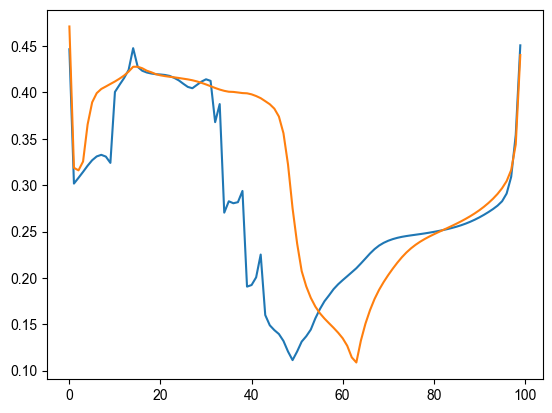

In [5]:
plt.plot(barycenter.flatten())
plt.plot(smooth_barycenter.flatten())

In [6]:
smooth_barycenter2 = nps.dn.get_consensus_signal_by_softdtw_barycenter_for_an_obj(obj=obj, re_smooth=False, smooth_att='lowpass_signal', seed=11)

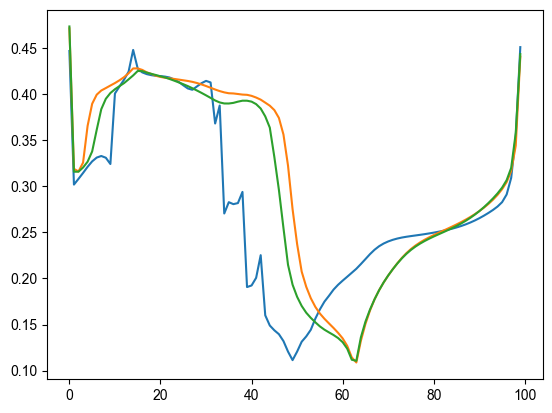

In [7]:
plt.plot(barycenter.flatten())
plt.plot(smooth_barycenter.flatten())
plt.plot(smooth_barycenter2.flatten())

In [5]:
# MIT License
#
# Copyright (c) 2020 Mehran Maghoumi
#
# Permission is hereby granted, free of charge, to any person obtaining a copy
# of this software and associated documentation files (the "Software"), to deal
# in the Software without restriction, including without limitation the rights
# to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
# copies of the Software, and to permit persons to whom the Software is
# furnished to do so, subject to the following conditions:
#
# The above copyright notice and this permission notice shall be included in all
# copies or substantial portions of the Software.
#
# THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
# IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
# FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
# AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
# LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
# OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
# SOFTWARE.
# ----------------------------------------------------------------------------------------------------------------------

import numpy as np
import torch
import torch.cuda
from numba import jit, prange
from torch.autograd import Function
from numba import cuda
import math

# ----------------------------------------------------------------------------------------------------------------------
@cuda.jit
def compute_softdtw_cuda(D, gamma, bandwidth, max_i, max_j, n_passes, R):
    """
    :param seq_len: The length of the sequence (both inputs are assumed to be of the same size)
    :param n_passes: 2 * seq_len - 1 (The number of anti-diagonals)
    """
    # Each block processes one pair of examples
    b = cuda.blockIdx.x
    # We have as many threads as seq_len, because the most number of threads we need
    # is equal to the number of elements on the largest anti-diagonal
    tid = cuda.threadIdx.x

    # Compute I, J, the indices from [0, seq_len)

    # The row index is always the same as tid
    I = tid

    inv_gamma = 1.0 / gamma

    # Go over each anti-diagonal. Only process threads that fall on the current on the anti-diagonal
    for p in range(n_passes):

        # The index is actually 'p - tid' but need to force it in-bounds
        J = max(0, min(p - tid, max_j - 1))

        # For simplicity, we define i, j which start from 1 (offset from I, J)
        i = I + 1
        j = J + 1

        # Only compute if element[i, j] is on the current anti-diagonal, and also is within bounds
        if I + J == p and (I < max_i and J < max_j):
            # Don't compute if outside bandwidth
            if not (abs(i - j) > bandwidth > 0):
                r0 = -R[b, i - 1, j - 1] * inv_gamma
                r1 = -R[b, i - 1, j] * inv_gamma
                r2 = -R[b, i, j - 1] * inv_gamma
                rmax = max(max(r0, r1), r2)
                rsum = math.exp(r0 - rmax) + math.exp(r1 - rmax) + math.exp(r2 - rmax)
                softmin = -gamma * (math.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin

        # Wait for other threads in this block
        cuda.syncthreads()

# ----------------------------------------------------------------------------------------------------------------------
@cuda.jit
def compute_softdtw_backward_cuda(D, R, inv_gamma, bandwidth, max_i, max_j, n_passes, E):
    k = cuda.blockIdx.x
    tid = cuda.threadIdx.x

    # Indexing logic is the same as above, however, the anti-diagonal needs to
    # progress backwards
    I = tid

    for p in range(n_passes):
        # Reverse the order to make the loop go backward
        rev_p = n_passes - p - 1

        # convert tid to I, J, then i, j
        J = max(0, min(rev_p - tid, max_j - 1))

        i = I + 1
        j = J + 1

        # Only compute if element[i, j] is on the current anti-diagonal, and also is within bounds
        if I + J == rev_p and (I < max_i and J < max_j):

            if math.isinf(R[k, i, j]):
                R[k, i, j] = -math.inf

            # Don't compute if outside bandwidth
            if not (abs(i - j) > bandwidth > 0):
                a = math.exp((R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) * inv_gamma)
                b = math.exp((R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) * inv_gamma)
                c = math.exp((R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) * inv_gamma)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c

        # Wait for other threads in this block
        cuda.syncthreads()

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTWCUDA(Function):
    """
    CUDA implementation is inspired by the diagonal one proposed in https://ieeexplore.ieee.org/document/8400444:
    "Developing a pattern discovery method in time series data and its GPU acceleration"
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.cuda.FloatTensor([gamma])
        bandwidth = torch.cuda.FloatTensor([bandwidth])

        B = D.shape[0]
        N = D.shape[1]
        M = D.shape[2]
        threads_per_block = max(N, M)
        n_passes = 2 * threads_per_block - 1

        # Prepare the output array
        R = torch.ones((B, N + 2, M + 2), device=dev, dtype=dtype) * math.inf
        R[:, 0, 0] = 0

        # Run the CUDA kernel.
        # Set CUDA's grid size to be equal to the batch size (every CUDA block processes one sample pair)
        # Set the CUDA block size to be equal to the length of the longer sequence (equal to the size of the largest diagonal)
        compute_softdtw_cuda[B, threads_per_block](cuda.as_cuda_array(D.detach()),
                                                   gamma.item(), bandwidth.item(), N, M, n_passes,
                                                   cuda.as_cuda_array(R))
        ctx.save_for_backward(D, R.clone(), gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors

        B = D.shape[0]
        N = D.shape[1]
        M = D.shape[2]
        threads_per_block = max(N, M)
        n_passes = 2 * threads_per_block - 1

        D_ = torch.zeros((B, N + 2, M + 2), dtype=dtype, device=dev)
        D_[:, 1:N + 1, 1:M + 1] = D

        R[:, :, -1] = -math.inf
        R[:, -1, :] = -math.inf
        R[:, -1, -1] = R[:, -2, -2]

        E = torch.zeros((B, N + 2, M + 2), dtype=dtype, device=dev)
        E[:, -1, -1] = 1

        # Grid and block sizes are set same as done above for the forward() call
        compute_softdtw_backward_cuda[B, threads_per_block](cuda.as_cuda_array(D_),
                                                            cuda.as_cuda_array(R),
                                                            1.0 / gamma.item(), bandwidth.item(), N, M, n_passes,
                                                            cuda.as_cuda_array(E))
        E = E[:, 1:N + 1, 1:M + 1]
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None


# ----------------------------------------------------------------------------------------------------------------------
#
# The following is the CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
# Credit goes to Kanru Hua.
# I've added support for batching and pruning.
#
# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw(D, gamma, bandwidth):
    B = D.shape[0]
    N = D.shape[1]
    M = D.shape[2]
    R = np.ones((B, N + 2, M + 2)) * np.inf
    R[:, 0, 0] = 0
    for b in prange(B):
        for j in range(1, M + 1):
            for i in range(1, N + 1):

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                r0 = -R[b, i - 1, j - 1] / gamma
                r1 = -R[b, i - 1, j] / gamma
                r2 = -R[b, i, j - 1] / gamma
                rmax = max(max(r0, r1), r2)
                rsum = np.exp(r0 - rmax) + np.exp(r1 - rmax) + np.exp(r2 - rmax)
                softmin = - gamma * (np.log(rsum) + rmax)
                R[b, i, j] = D[b, i - 1, j - 1] + softmin
    return R

# ----------------------------------------------------------------------------------------------------------------------
@jit(nopython=True, parallel=True)
def compute_softdtw_backward(D_, R, gamma, bandwidth):
    B = D_.shape[0]
    N = D_.shape[1]
    M = D_.shape[2]
    D = np.zeros((B, N + 2, M + 2))
    E = np.zeros((B, N + 2, M + 2))
    D[:, 1:N + 1, 1:M + 1] = D_
    E[:, -1, -1] = 1
    R[:, :, -1] = -np.inf
    R[:, -1, :] = -np.inf
    R[:, -1, -1] = R[:, -2, -2]
    for k in prange(B):
        for j in range(M, 0, -1):
            for i in range(N, 0, -1):

                if np.isinf(R[k, i, j]):
                    R[k, i, j] = -np.inf

                # Check the pruning condition
                if 0 < bandwidth < np.abs(i - j):
                    continue

                a0 = (R[k, i + 1, j] - R[k, i, j] - D[k, i + 1, j]) / gamma
                b0 = (R[k, i, j + 1] - R[k, i, j] - D[k, i, j + 1]) / gamma
                c0 = (R[k, i + 1, j + 1] - R[k, i, j] - D[k, i + 1, j + 1]) / gamma
                a = np.exp(a0)
                b = np.exp(b0)
                c = np.exp(c0)
                E[k, i, j] = E[k, i + 1, j] * a + E[k, i, j + 1] * b + E[k, i + 1, j + 1] * c
    return E[:, 1:N + 1, 1:M + 1]

# ----------------------------------------------------------------------------------------------------------------------
class _SoftDTW(Function):
    """
    CPU implementation based on https://github.com/Sleepwalking/pytorch-softdtw
    """

    @staticmethod
    def forward(ctx, D, gamma, bandwidth):
        dev = D.device
        dtype = D.dtype
        gamma = torch.Tensor([gamma]).to(dev).type(dtype)  # dtype fixed
        bandwidth = torch.Tensor([bandwidth]).to(dev).type(dtype)
        D_ = D.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        R = torch.Tensor(compute_softdtw(D_, g_, b_)).to(dev).type(dtype)
        ctx.save_for_backward(D, R, gamma, bandwidth)
        return R[:, -2, -2]

    @staticmethod
    def backward(ctx, grad_output):
        dev = grad_output.device
        dtype = grad_output.dtype
        D, R, gamma, bandwidth = ctx.saved_tensors
        D_ = D.detach().cpu().numpy()
        R_ = R.detach().cpu().numpy()
        g_ = gamma.item()
        b_ = bandwidth.item()
        E = torch.Tensor(compute_softdtw_backward(D_, R_, g_, b_)).to(dev).type(dtype)
        return grad_output.view(-1, 1, 1).expand_as(E) * E, None, None

# ----------------------------------------------------------------------------------------------------------------------
class SoftDTW(torch.nn.Module):
    """
    The soft DTW implementation that optionally supports CUDA
    """

    def __init__(self, use_cuda, gamma=1.0, normalize=False, bandwidth=None, dist_func=None):
        """
        Initializes a new instance using the supplied parameters
        :param use_cuda: Flag indicating whether the CUDA implementation should be used
        :param gamma: sDTW's gamma parameter
        :param normalize: Flag indicating whether to perform normalization
                          (as discussed in https://github.com/mblondel/soft-dtw/issues/10#issuecomment-383564790)
        :param bandwidth: Sakoe-Chiba bandwidth for pruning. Passing 'None' will disable pruning.
        :param dist_func: Optional point-wise distance function to use. If 'None', then a default Euclidean distance function will be used.
        """
        super(SoftDTW, self).__init__()
        self.normalize = normalize
        self.gamma = gamma
        self.bandwidth = 0 if bandwidth is None else float(bandwidth)
        self.use_cuda = use_cuda

        # Set the distance function
        if dist_func is not None:
            self.dist_func = dist_func
        else:
            self.dist_func = SoftDTW._euclidean_dist_func

    def _get_func_dtw(self, x, y):
        """
        Checks the inputs and selects the proper implementation to use.
        """
        bx, lx, dx = x.shape
        by, ly, dy = y.shape
        # Make sure the dimensions match
        # assert bx == by  # Equal batch sizes
        assert dx == dy  # Equal feature dimensions

        use_cuda = self.use_cuda

        if use_cuda and (lx > 1024 or ly > 1024):  # We should be able to spawn enough threads in CUDA
                print("SoftDTW: Cannot use CUDA because the sequence length > 1024 (the maximum block size supported by CUDA)")
                use_cuda = False

        # Finally, return the correct function
        return _SoftDTWCUDA.apply if use_cuda else _SoftDTW.apply

    @staticmethod
    def _euclidean_dist_func(x, y):
        """
        Calculates the Euclidean distance between each element in x and y per timestep
        """
        n = x.size(1)
        m = y.size(1)
        d = x.size(2)
        x = x.unsqueeze(2).expand(-1, n, m, d)
        y = y.unsqueeze(1).expand(-1, n, m, d)
        return torch.pow(x - y, 2).sum(3)

    def forward(self, X, Y):
        """
        Compute the soft-DTW value between X and Y
        :param X: One batch of examples, batch_size x seq_len x dims
        :param Y: The other batch of examples, batch_size x seq_len x dims
        :return: The computed results
        """

        # Check the inputs and get the correct implementation
        func_dtw = self._get_func_dtw(X, Y)

        if self.normalize:
            # Stack everything up and run
            x = torch.cat([X, X, Y])
            y = torch.cat([Y, X, Y])
            D = self.dist_func(x, y)
            out = func_dtw(D, self.gamma, self.bandwidth)
            out_xy, out_xx, out_yy = torch.split(out, X.shape[0])
            return out_xy - 1 / 2 * (out_xx + out_yy)
        else:
            D_xy = self.dist_func(X, Y)
            return func_dtw(D_xy, self.gamma, self.bandwidth)

In [58]:
m = SoftDTW(use_cuda=True)
m = m.to(torch.device("cuda"))

In [120]:
import copy
# X = torch.Tensor([[
#                     [1.0],
#                     [2.0],
#                     [3.1],
#                     [4.0],
#                     [5.1],
#                     [3.1],
#                     [1.0]
#                   ]])
# Y = torch.Tensor([[
#                     [1.0],
#                     [2.0],
#                     [3.1],
#                     [4.0],
#                     [5.1],
#                     [3.1],
#                     [1.0]
#                   ],
                 
#                 [
#                     [1.0],
#                     [2.0],
#                     [3.1],
#                     [4.0],
#                     [5.1],
#                     [3.1],
#                     [1.1]
#                   ]
                                   
#                  ])

X = torch.randn(1,100,1)
Y = torch.randn(10,100,1)
X = X.to(torch.device("cuda"))
Y = Y.to(torch.device("cuda"))
X = X.requires_grad_(True)  

In [127]:
l = torch.mean(m(X,Y))
l.backward()

In [103]:
X.grad.shape

torch.Size([1, 7, 1])

In [112]:
l

tensor([-2.4622], device='cuda:0', grad_fn=<_SoftDTWCUDABackward>)

In [119]:
l

tensor([-2.4622, -2.4583], device='cuda:0', grad_fn=<_SoftDTWCUDABackward>)

In [8]:
X_df = npsc.get_X_from_an_obj(obj)

In [9]:
m = SoftDTW(use_cuda=True)
device = torch.device("cuda")
m = m.to(device)

In [19]:
batch_size = 64
train_dl = npsc.construct_dataloader_from_data_df(X_df, batch_size=batch_size,)

In [11]:
X = torch.randn(1,1000,1)
X = X.to(torch.device("cuda"))
X = X.requires_grad_(True)  

In [26]:
params = [
    {'params': m.parameters()},
    {'params': [X]}  # 注意要放入列表
]

optimizer = torch.optim.Adam(params, lr=0.001)

In [28]:
for epoch in range(10):
    m.train()
    loss_in_one_epoch = []
    for indx, (read_ids, Y) in enumerate(train_dl):
        Y = Y.to(device)
        Y = Y[:,:,None]
        loss = torch.mean(m(X,Y))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        loss_in_one_epoch.append(loss.item())
    print(f'{epoch} {np.mean(loss_in_one_epoch)}')

0 -370.6373144372717
1 -382.0687922612056
2 -383.96686406854866
3 -383.99511657775815
4 -383.99429607867717
5 -383.9937874015633
6 -383.99358652212044
7 -383.9929283363121
8 -383.99326555402604
9 -383.99350698129996


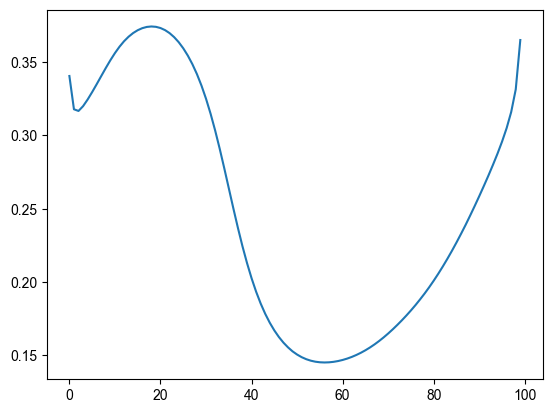

In [36]:
plt.plot(X.cpu().detach().numpy()[0].flatten())